## Import modules

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from operator import itemgetter
pd.set_option('display.max_colwidth', 800)

START_DATE = "2020/"

## Import Data

In [ ]:
import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
tweets = spark.read.csv("/mnt/datastore/data/antivax/users_streamed/*.csv");
tweets.count()

In [17]:
path = r'/mnt/datastore/data/antivax/timelines' 
all_files = glob.glob(path + "/*.csv")

li = []
count=0
for i, filename in enumerate(all_files):
    try: 
        df = pd.read_csv(filename, index_col=None, header=0)
        if(df.shape[0] > 1):
            count+=1
            print("count = {} - {}/{}\r".format(count, i, len(all_files)), end="")
            li.append(df)
    except Exception as e:
        print(filename, e)

tweets = pd.concat(li, axis=0, ignore_index=True)
tweets = tweets[~tweets['created_at'].isna()]
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets.head(3)

KeyError: 'created_at'

In [5]:
users = tweets.user_name.unique().tolist()

In [98]:
import ast
from collections import defaultdict

def get_interactions(row):
    user = row["user_id"], row["user_name"]
    
    if user[0] is None:
        return (None, None), []
    
    interactions = set()
    
    if(pd.notna(row["in_reply_to_user_id"])):
        interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    if(pd.notna(row["retweeted_from_user_id"])):
        interactions.add((row["retweeted_from_user_id"], row["retweeted_from_user_name"]))
    for i, id_ in enumerate(row["user_mentions_ids"]):
        interactions.add((str(id_), row["user_mentions_names"][i]))
        
    interactions.discard((row["user_id"], row["user_name"]))
    interactions.discard((float("nan"), float("nan")))
    return user, interactions

path = r'/mnt/datastore/data/antivax/users_stream' 
all_files = glob.glob(path + "/*.csv")

users_interactions = defaultdict(list)
count=0
for i, filename in enumerate(all_files):
    try: 
        header = ["tweet_id", "user_id", "user_name", "followers", "friends", "user_location", "likes", "retweets", "text", "created_at", "urls", "in_reply_to_user_id", "in_reply_to_screen_name", "user_mentions_ids", "user_mentions_names", "retweeted_from_user_id", "retweeted_from_user_name"]
        df = pd.read_csv(filename, header=None, names=header, dtype="str")
        
        df["user_mentions_ids"] = df["user_mentions_ids"].apply(lambda x: ast.literal_eval(x))
        df["user_mentions_names"] = df["user_mentions_names"].apply(lambda x: ast.literal_eval(x))
        
        for index, row in df.iterrows():
            user, interaction = get_interactions(row)
            users_interactions[user].append(list(interaction))
        count+=1
        print("count = {} - {}/{}\r".format(count, i, len(all_files)), end="")
    except Exception as e:
        print(filename, e)

#tweets = pd.concat(li, axis=0, ignore_index=True, header=None)
#tweets = tweets[~tweets['created_at'].isna()]
#tweets['created_at'] = pd.to_datetime(tweets['created_at'])
#tweets.head(3)
users_interactions

defaultdict(list,
            {('1169663811374243840',
              'SuellenSeabury'): [[('25073877',
                'realDonaldTrump')], [('25073877', 'realDonaldTrump')]],
             ('786929797419106304',
              'shellygrace75'): [[('25073877', 'realDonaldTrump')]],
             ('737448300861759488',
              'vivkassa'): [[('25073877', 'realDonaldTrump')]],
             ('1147610846119391232',
              '1960yzxw1028'): [[('25073877', 'realDonaldTrump')]],
             ('3394447038',
              'babarali7854'): [[('25073877', 'realDonaldTrump')]],
             ('838852020828323840',
              'Orlane48654851'): [[('1214315619031478272', 'Conflits_FR')]],
             ('971267882008145921',
              'KishereFilm'): [[('3131144855', 'BorisJohnson')]],
             ('983869347629273089',
              'PhillipG1998'): [[('44196397', 'elonmusk')]],
             ('365519583',
              'ronydy_hangy'): [[('25073877', 'realDonaldTrump')]],
           

In [81]:
header = ["tweet_id", "user_id", "user_name", "followers", "friends", "user_location", "likes", "retweets", "text", "created_at", "urls", "in_reply_to_user_id", "in_reply_to_screen_name", "user_mentions_ids", "user_mentions_names", "retweeted_from_user_id", "retweeted_from_user_name"]
df = pd.read_csv(all_files[2], header=None, names=header, dtype="str")
df.head()

,tweet_id,user_id,user_name,followers,friends,user_location,likes,retweets,text,created_at,urls,in_reply_to_user_id,in_reply_to_screen_name,user_mentions_ids,user_mentions_names,retweeted_from_user_id,retweeted_from_user_name
0,1260162243112701952,17735769,Krell1,55,53,"New York, NY",0,0,@realDonaldTrump Makes the mind wobble that you think this makes you look good. They way you stomped out reminded me of the 2017 Face the Nation interview where you ended the interview and petulantly shuffled paper. Good part starts at 7:20. https://t.co/wpHrLrm9F6,2020-05-12 10:57:46,"[{'url': 'https://t.co/T2TR36BXCO', 'expanded_url': 'https://twitter.com/i/web/status/1260162243112701952', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",25073877,realDonaldTrump,['25073877'],['realDonaldTrump'],NaN,NaN
1,1260162604951101440,17735769,Krell1,55,53,"New York, NY",0,0,"@realDonaldTrump A weak leader runs, or sits like this interview from 2017, begin at 7:20. https://t.co/wpHrLrm9F6",2020-05-12 10:59:12,"[{'url': 'https://t.co/wpHrLrm9F6', 'expanded_url': 'https://www.youtube.com/watch?v=CF8lzCL5ncE&fbclid=IwAR2kUf3vVqcbuxi3vp9OeuPV1WHePJTxgR2gknclwtv_rFgh9L9JGNe87gM', 'display_url': 'youtube.com/watch?v=CF8lzC…', 'indices': [91, 114]}]",25073877,realDonaldTrump,['25073877'],['realDonaldTrump'],NaN,NaN
2,1260162916965404672,17735769,Krell1,55,53,"New York, NY",0,0,@realDonaldTrump You couldn't manage to say what Obamagate was in your press conference. You must be really worried about those SC cases involving your finances.,2020-05-12 11:00:26,"[{'url': 'https://t.co/JvxW8g8nxM', 'expanded_url': 'https://twitter.com/i/web/status/1260162916965404672', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",25073877,realDonaldTrump,['25073877'],['realDonaldTrump'],NaN,NaN
3,1260163483510935552,17735769,Krell1,55,53,"New York, NY",0,0,"@realDonaldTrump Ratings concern you? 81.5+ dead and rural areas surging, per your own report, but ratings? https://t.co/iGZWKLCt05",2020-05-12 11:02:41,"[{'url': 'https://t.co/iGZWKLCt05', 'expanded_url': 'https://www.msn.com/en-us/news/politics/white-house-report-shows-coronavirus-rates-spiking-in-heartland/ar-BB13Wi0a?ocid=spartanntp', 'display_url': 'msn.com/en-us/news/pol…', 'indices': [108, 131]}]",25073877,realDonaldTrump,['25073877'],['realDonaldTrump'],NaN,NaN
4,1260164127424724992,17735769,Krell1,55,53,"New York, NY",0,0,@realDonaldTrump Nut job....who tweets and sounds like a nut job.....,2020-05-12 11:05:15,[],25073877,realDonaldTrump,['25073877'],['realDonaldTrump'],NaN,NaN


In [94]:
import ast
import math
#df["user_mentions_ids"] = df["user_mentions_ids"].apply(lambda x: ast.literal_eval(x))
#df["user_mentions_names"] = df["user_mentions_names"].apply(lambda x: ast.literal_eval(x))

# Get the interactions between the different users
def get_interactions(row):
    user = row["user_id"], row["user_name"]
    
    if user[0] is None:
        return (None, None), []
    
    interactions = set()
    
    if(pd.notna(row["in_reply_to_user_id"])):
        interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    if(pd.notna(row["retweeted_from_user_id"])):
        interactions.add((row["retweeted_from_user_id"], row["retweeted_from_user_name"]))
    for i, id_ in enumerate(row["user_mentions_ids"]):
        interactions.add((str(id_), row["user_mentions_names"][i]))
        
    interactions.discard((row["user_id"], row["user_name"]))
    interactions.discard((float("nan"), float("nan")))
    return user, interactions


for index, row in df.iterrows():
    print(get_interactions(row))

(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})
(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})
(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})
(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})
(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})
(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})
(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})
(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})
(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})
(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})
(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})
(('17735769', 'Krell1'), {('25073877', 'realDonaldTrump')})


In [49]:
# Parse user mentions
df['user_mentions_id'] = df["user_mentions"].str.find("'id_str': '(25073877)'")
df['user_mentions_screen_name'] = df["user_mentions"].str.find("'screen_name': '(\w+)'")

# Parse retweets infos
# Parse retweets infos
#df["user_mentions_id"] = df[~df["user_mentions"].isna()].user_mentions.apply(lambda x: json.loads(x)['screen_name'])
#df["retweeted_id"] = df[~df["retweeted_status"].isna()].retweeted_status.apply(lambda x: json.loads(x)['user']['id_str'])
# Convert Ids to numeric
#df["in_reply_to_user_id"] = pd.to_numeric(df["in_reply_to_user_id"], errors='coerce')
#df["retweeted_id"] = pd.to_numeric(df["retweeted_id"], errors='coerce')
#df["user_mentions_id"] = pd.to_numeric(df["user_mentions_id"], errors='coerce')
#df["user_id"] = pd.to_numeric(df["user_id"], errors='coerce')
df.head()

,tweet_id,user_id,user_name,followers,friends,user_location,likes,retweets,text,created_at,urls,in_reply_to_user_id,in_reply_to_screen_name,user_mentions,retweeted_from_user_id,retweeted_from_user_name,user_mentions_id,user_mentions_screen_name
0,1260156937221660674,822643909343973378,MsSwis,511,210,NaN,0,0,@realDonaldTrump Really great resource tool if your not familiar with the #ObaMAGAte players. 👇\n\n#Spygate is #Obamagate \n#Obamagate is #Treason \n\n#WWG1WGA \n\nhttps://t.co/8gB4HgnlCh,2020-05-12 10:36:41,"[{'url': 'https://t.co/juiP7KuGnh', 'expanded_url': 'https://twitter.com/i/web/status/1260156937221660674', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [110, 133]}]",25073877,realDonaldTrump,"[{'screen_name': 'realDonaldTrump', 'name': 'Donald J. Trump', 'id': 25073877, 'id_str': '25073877', 'indices': [0, 16]}]",NaN,NaN,-1,-1
1,1260157258232745984,822643909343973378,MsSwis,511,210,NaN,0,0,"A great time to have strong Borders, and we now have the strongest Borders in our history. 182 miles of Border Wall already built! Dems want Open Borders, let EVERYONE IN. No thanks! https://t.co/XdW55c0kKv",2020-05-12 10:37:57,[],NaN,NaN,"[{'screen_name': 'realDonaldTrump', 'name': 'Donald J. Trump', 'id': 25073877, 'id_str': '25073877', 'indices': [3, 19]}]",25073877,realDonaldTrump,-1,-1
2,1260157283474059266,822643909343973378,MsSwis,511,210,NaN,0,0,@realDonaldTrump Really great resource tool if your not familiar with the #ObaMAGAte players. 👇\n\n#Spygate is #Obamagate \n#Obamagate is #Treason \n\n#WWG1WGA \n\nhttps://t.co/8gB4HgnlCh,2020-05-12 10:38:03,"[{'url': 'https://t.co/Q1a72Heauy', 'expanded_url': 'https://twitter.com/i/web/status/1260157283474059266', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [110, 133]}]",25073877,realDonaldTrump,"[{'screen_name': 'realDonaldTrump', 'name': 'Donald J. Trump', 'id': 25073877, 'id_str': '25073877', 'indices': [0, 16]}]",NaN,NaN,-1,-1


In [10]:
tweets.head()

,1259183719212109825,1169663811374243840,SuellenSeabury,126,208,"New Hampshire, USA",0,0.1,"@WhiteHouse I hope everyone thoroughly read the CDC guidelines that had been previously buried by the White House and recently revealed to the American public, thanks to the hard-working Fake Media. There will be a pop quiz on Monday at 10:00 a.m.",2020-05-09 18:09:27,...,@realDonaldTrump O m g what did President Obama do to you for you to be so freaking crazy over him,2020-05-12 03:41:33,1259180670997454850,584311330,cherokeenatv46,4418,5004,"@realDonaldTrump\nPlease, please do not sign any bill. They want Mail in voting, ballot harvesting. Please do not give them anything. \nREPORT: Trump says ‘no rush’ on new stimulus package https://t.co/qL77ed51DT via @realdennislynch",2020-05-09 17:57:21,"[{'url': 'https://t.co/TSSieXaLPy', 'expanded_url': 'https://twitter.com/i/web/status/1259180670997454850', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]"
0,1.259213e+18,1.169664e+18,SuellenSeabury,128.0,210.0,"New Hampshire, USA",0,0,@elonmusk @GerberKawasaki @thirdrowtesla Your new baby wants to be adopted by two responsible adults.,2020-05-09 20:06:58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.259215e+18,1.169664e+18,SuellenSeabury,128.0,210.0,"New Hampshire, USA",0,0,@realDonaldTrump @GavinNewsom @MikeGarcia2020 Has your valet shaked your hand today?,2020-05-09 20:13:08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.259255e+18,1.169664e+18,SuellenSeabury,128.0,210.0,"New Hampshire, USA",0,0,"@WhiteHouse @realDonaldTrump @EsperDoD @SecPompeo Each of them less than six feet apart from one another; none wearing a mask and based upon the length of the meeting and spread of respiratory droplets, at least four of them will test positive for COVID by May 24. It’s not “rocket science,” gentlemen, it’s just SCIENCE.",2020-05-09 22:53:52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.259583e+18,1.169664e+18,SuellenSeabury,132.0,211.0,"New Hampshire, USA",0,0,@realDonaldTrump Lure 45 outside and then LOCK THE FRONT GATE!,2020-05-10 20:35:20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.259971e+18,1.169664e+18,SuellenSeabury,135.0,215.0,"New Hampshire, USA",0,0,"@realDonaldTrump If there’s a disgrace to America, it’s the fat man who sits in the Oval Office.",2020-05-11 22:18:48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [283]:
print(len(tweets['user_id'].unique()))

users_ids = tweets['user_id'].unique()
users_ids = [str(user_id) for user_id in users_ids]


593


In [284]:
import pickle

with open("../scripts/seeds_ids.txt", "wb") as fp:   #Pickling
    pickle.dump(users_ids, fp)

In [273]:
tweets.groupby('user_name').count()

,tweet_id,user_id,followers,friends,user_location,likes,retweets,text,created_at,urls,in_reply_to_user_id,in_reply_to_screen_name,user_mentions,retweeted_status,user_mentions_id,user_mentions_screen_name,retweeted_screen_name,retweeted_id
user_name,,,,,,,,,,,,,,,,,,
19h30RTS,679,679,679,679,679,679,679,679,679,679,7,7,679,223,679,679,223,223
1RiposteLaique,2199,2199,2199,2199,0,2199,2199,2199,2199,2199,0,0,2199,0,2199,2199,0,0
20minutesOnline,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,8,8,1531,57,1531,1531,57,57
24heuresch,2599,2599,2599,2599,2599,2599,2599,2599,2599,2599,31,31,2599,719,2599,2599,719,719
4h6r4kpf,633,633,633,633,0,633,633,633,633,633,16,16,633,185,633,633,185,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wikileaks,782,782,782,782,782,782,782,782,782,782,51,51,782,362,782,782,362,362
withnomoney,2433,2433,2433,2433,2433,2433,2433,2433,2433,2433,862,862,2433,637,2433,2433,637,637
womandream,1426,1426,1426,1426,0,1426,1426,1426,1426,1426,725,725,1426,190,1426,1426,190,190


In [178]:
# Filter to have the same scale
print(tweets.count())
tweets = tweets[(tweets['created_at'] < "2020-04-01") & (tweets['created_at'] > "2019-09-01")]
tweets.count()

tweet_id                   1511130
user_id                    1511130
user_name                  1511130
followers                  1511130
friends                    1511130
user_location              1083045
likes                      1511130
retweets                   1511130
text                       1511130
created_at                 1511130
urls                       1511130
in_reply_to_user_id         325884
in_reply_to_screen_name     325884
user_mentions              1511130
retweeted_status            522596
dtype: int64


tweet_id                   518711
user_id                    518711
user_name                  518711
followers                  518711
friends                    518711
user_location              376488
likes                      518711
retweets                   518711
text                       518711
created_at                 518711
urls                       518711
in_reply_to_user_id        119809
in_reply_to_screen_name    119809
user_mentions              518711
retweeted_status           180855
dtype: int64

## Clean Data

In [179]:
# Parse user mentions
tweets['user_mentions_id'] = tweets["user_mentions"].str.find("ID=([0-9]+),")
tweets['user_mentions_screen_name'] = tweets["user_mentions"].str.find("ScreenName=(\w+)\)")


In [180]:
# Parse retweets infos
tweets["retweeted_screen_name"] = tweets[~tweets["retweeted_status"].isna()].retweeted_status.apply(lambda x: json.loads(x)['user']['screen_name'])
tweets["retweeted_id"] = tweets[~tweets["retweeted_status"].isna()].retweeted_status.apply(lambda x: json.loads(x)['user']['id_str'])

In [181]:
# Convert Ids to numeric
tweets["in_reply_to_user_id"] = pd.to_numeric(tweets["in_reply_to_user_id"], errors='coerce')
tweets["retweeted_id"] = pd.to_numeric(tweets["retweeted_id"], errors='coerce')
tweets["user_mentions_id"] = pd.to_numeric(tweets["user_mentions_id"], errors='coerce')
tweets["user_id"] = pd.to_numeric(tweets["user_id"], errors='coerce')

In [64]:
# Get the interactions between the different users
def get_interactions(row):
    user = row["user_id"], row["user_name"]
    
    if user[0] is None:
        return (None, None), []
    
    interactions = set()
    
    interactions.add((str(row["in_reply_to_user_id"]), row["in_reply_to_screen_name"]))
    interactions.add((str(row["retweeted_id"]), row["retweeted_screen_name"]))
    interactions.add((str(row["user_mentions_id"]), row["user_mentions_screen_name"]))
        
    interactions.discard((row["user_id"], row["user_name"]))
    interactions.discard((None, None))
    return user, interactions

In [275]:
TOP_USERS = 100
all_users = np.append(tweets.user_name,tweets.in_reply_to_screen_name)
all_users = np.append(all_users, tweets.retweeted_screen_name)
all_users = np.append(all_users, tweets.user_mentions_screen_name)
all_users = pd.DataFrame(all_users)
important_users = all_users[0].value_counts()[1:TOP_USERS]
important_users = list(important_users.keys())

In [277]:
all_users[0].value_counts()

-1               518711
JeanMessiha        4421
DidierMaisto       4171
Damocles_Fr        4128
patrick_edery      4101
                  ...  
LeCollegeMG           1
PsychRecovery         1
RomainSajous          1
anglowaffen           1
degimli42             1
Name: 0, Length: 46439, dtype: int64

In [246]:
seed_users = np.unique(tweets.user_name.values).tolist()
#filter_users = list(set(seed_users) | set(important_users)) 

filter_users = seed_users
len(seed_users)

499

In [247]:
tweets_filtered = tweets[tweets.in_reply_to_screen_name.isin(filter_users) 
       | tweets.retweeted_screen_name.isin(filter_users)
       | tweets.user_mentions_screen_name.isin(filter_users)]
tweets_filtered = tweets_filtered.reset_index()
tweets_filtered = tweets_filtered.where((pd.notnull(tweets_filtered)), None)
tweets_filtered.shape[0]

94991

## Build the graph

In [248]:
#graph = nx.Graph()
graph = nx.DiGraph()
#graph.add_nodes_from(filter_users)
for index, tweet in tweets_filtered.iterrows():
    print("{}/{}\r".format(index, tweets_filtered.shape[0]), end="")
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    #tweet_id = tweet["tweet_id"]
    for interaction in interactions:
        int_id, int_name = interaction
        if(user_name in filter_users and int_name in filter_users):
            # Add or update node user
            if graph.has_node(user_name):
                graph.nodes[user_name]['weight'] += 1
            else:
                graph.add_node(user_name, weight=1)
            
            # Add or update node interaction
            if graph.has_node(int_name):
                graph.nodes[int_name]['weight'] += 1
            else:
                graph.add_node(int_name, weight=1)
            
            # Add or update edge user - interaction
            if graph.has_edge(user_name, int_name):
                graph[user_name][int_name]['weight'] += 1
            else:
                graph.add_edge(user_name, int_name, weight=1)

## Infos on the graph

There are 474 nodes and 11948 edges present in the Graph


In [249]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

degrees = [val for (node, val) in graph.degree()]

print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")

if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")
    
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
largest_subgraph = max(connected_component_subgraphs(graph), key=len)

number_of_nodes = largest_subgraph.number_of_nodes()
number_of_edges = largest_subgraph.number_of_edges()

print(f"There are {number_of_nodes} nodes and {number_of_edges} \
edges present in the largest component of the Graph")

There are 473 nodes and 12951 edges present in the Graph
The maximum degree of the Graph is 230
The minimum degree of the Graph is 1


NetworkXNotImplemented: not implemented for directed type

In [ ]:
#print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
#print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

In [ ]:
#print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
#print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

In [250]:
largest_subgraph = graph
import heapq
top = 5
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = heapq.nlargest(top,graph_centrality.items(), key=itemgetter(1))
#max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = heapq.nlargest(top,graph_closeness.items(), key=itemgetter(1))
#max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = heapq.nlargest(top,graph_betweenness.items(), key=itemgetter(1))
#max_bet = max(graph_betweenness.items(), key=itemgetter(1))

print("Centrality Degree:")
print(max_de)
print("Closeness Centrality:")
print(max_clo)
print("Betweenness Centrality:")
print(max_bet)

#print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
#print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

Centrality Degree:
[('SJallamion', 0.4872881355932203), ('DamienRieu', 0.4851694915254237), ('patrick_edery', 0.4152542372881356), ('JeanMessiha', 0.4046610169491525), ('jylgallou', 0.3919491525423729)]
Closeness Centrality:
[('Valeurs', 0.46458712704860616), ('dr_l_alexandre', 0.45430935085898766), ('DamienRieu', 0.45307648966262676), ('EmmanuelMacron', 0.44641360010876463), ('afpfr', 0.4462788496213487)]
Betweenness Centrality:
[('SJallamion', 0.04789916483141612), ('jmjm817', 0.03868503327011858), ('DamienRieu', 0.03544342898005792), ('patrick_edery', 0.034618667536043764), ('DariusRochebin', 0.03420447681561842)]


In [251]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = 'red'
central_nodes =  list(list(zip(*max_de))[0])#['tprincedelamour']

In [252]:
pos = nx.spring_layout(largest_subgraph)

In [253]:
nodes_weights = list(list(zip(*list(largest_subgraph.nodes.data('weight'))))[1])

In [254]:
seed_users = list(filter(lambda node: node in list(largest_subgraph.nodes()), seed_users))
important_users = list(filter(lambda node: node in list(largest_subgraph.nodes()) and node not in seed_users, important_users))

## Community Detection

In [260]:
# Compute community detection
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms import community

numberOfClusters = 3

communities_generator = community.girvan_newman(largest_subgraph)
for i in range(numberOfClusters - 1):
    next_level_communities = next(communities_generator)
communities = sorted(map(sorted, next_level_communities))
len(communities)

4

In [259]:
communities

[['19h30RTS',
  '1RiposteLaique',
  '20minutesOnline',
  '24heuresch',
  '4h6r4kpf',
  'AQuatennens',
  'Abdou64533132',
  'Actu17',
  'AigleRoyal06',
  'Al_Bundy_lro',
  'AlainSoralOffic',
  'AldoSterone111',
  'AlexDevecchio',
  'Alexis_Cossette',
  'AllPourLaFrance',
  'AnaLignier',
  'AndreaKotarac',
  'AnneFarmer65',
  'AnneTP33',
  'AntiChemtrails',
  'AntoineBaudino',
  'Aramisunchained',
  'ArianeWalter',
  'Arille_Tella',
  'BBrocard',
  'BVoltaire',
  'BarackObama',
  'BeatriceMarty',
  'Bernard_Rappaz',
  'BilgerPhilippe',
  'BlaiseElise',
  'BorisJohnson',
  'BoschettiSteen',
  'BouloGiletJaune',
  'BoussageonR',
  'Breizh_Info',
  'Brevesdepresse',
  'BrunoLeMaire',
  'BrunoRetailleau',
  'BuchardD',
  'CCastaner',
  'CHmarmotte',
  'CRE_SciencesPo',
  'CWeillRaynal',
  'C_Barbier',
  'CapuPatriote',
  'CatherineRiva',
  'Causeur',
  'CedreHumanitrad',
  'CercleVoltaire',
  'CerdagneFrance',
  'CerveauxNon',
  'ChLECHEVALIER',
  'ChWilhou',
  'CheeperOff',
  'Christheswiss

In [262]:
from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(largest_subgraph, weight='weight')
len(communities)

IndexError: list index out of range

In [263]:
from networkx.algorithms.community import asyn_lpa_communities
communities = list(asyn_lpa_communities(graph, weight='weight'))
len(communities)

95

In [264]:
communities

[{'24heuresch', 'lematindimanche'},
 {'AigleRoyal06',
  'Al_Bundy_lro',
  'AldoSterone111',
  'AlexDevecchio',
  'AllPourLaFrance',
  'AnneFarmer65',
  'AntiChemtrails',
  'Aramisunchained',
  'ArianeWalter',
  'BVoltaire',
  'BeatriceMarty',
  'BilgerPhilippe',
  'BlaiseElise',
  'BouloGiletJaune',
  'Breizh_Info',
  'BrunoRetailleau',
  'CHmarmotte',
  'CWeillRaynal',
  'C_Barbier',
  'CapuPatriote',
  'CedreHumanitrad',
  'CercleVoltaire',
  'CerdagneFrance',
  'ChWilhou',
  'Christheswiss72',
  'Christianophobi',
  'Civitas_',
  'CocardeEtud',
  'ComplotsFaciles',
  'CretinusAlp',
  'CtrlAltDroite',
  'DIVIZIO1',
  'D_Conversano',
  'DamienRieu',
  'David_vanH',
  'DianeRi76665944',
  'Drmartyufml',
  'E2Villiers',
  'ECiotti',
  'Elise__Lacroix',
  'Enthoven_R',
  'EugenieBastie',
  'FX_Obrador',
  'F_Desouche',
  'FallaitPasSuppr',
  'FlorentGouault',
  'FrDesouche',
  'Fr_Conservateur',
  'FranceEnGuerre',
  'FrancePolitic',
  'FranckBam',
  'GG_RMC',
  'GWGoldnadel',
  'Gaspard

In [265]:
# Add community number to node
for node in largest_subgraph.nodes():
    largest_subgraph.nodes[node]['group'] = next(i for i,v in enumerate(communities) if node in v)


## Visualize 

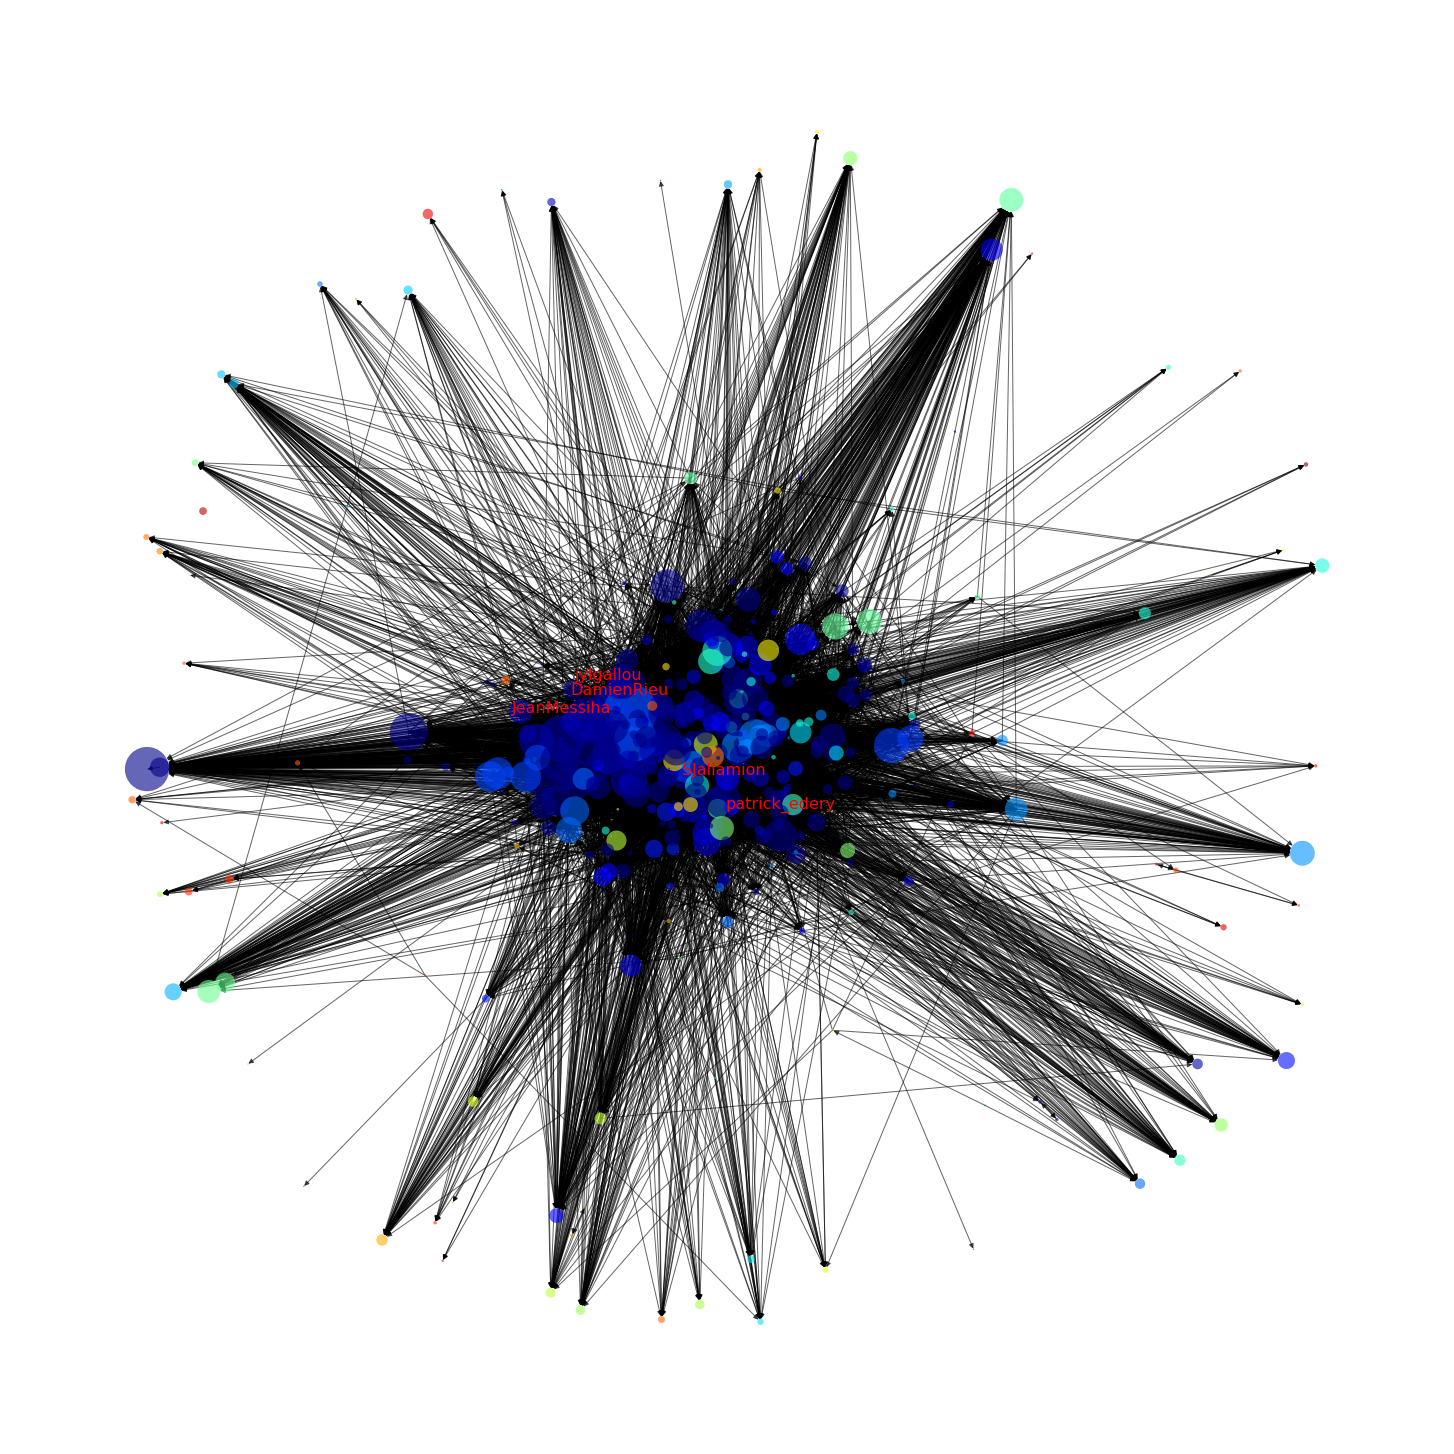

In [266]:
import matplotlib
plt.figure(figsize = (20,20))

groups = range(len(communities))
nodes = largest_subgraph.nodes()
colors = [next(i for i,v in enumerate(communities) if n in v) for n in nodes]

nx.draw(largest_subgraph, font_weight='bold', pos=pos, node_color=colors, cmap=plt.cm.jet, edge_color="black", linewidths=0.3, node_size=nodes_weights, alpha=0.6, with_labels=False)
#nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes, with_labels=True)
'''
nodes_colors = matplotlib.cm.ScalarMappable(
      norm = matplotlib.colors.Normalize(0, len(communities)), 
      cmap = plt.cm.PiYG)
for i, c in enumerate(communities):
    nodes_weights = list(list(zip(*list(graph.nodes.data('weight'))))[1])
    nx.draw_networkx_nodes(largest_subgraph,pos,
                       nodelist=list(c),
                       node_color=nodes_colors.to_rgba(i),
                       #cmap=plt.cm.PiYG,
                       node_size=nodes_weights,
                       alpha=0.8)
                       
                       
    
nx.draw_networkx_edges(largest_subgraph,pos,alpha=0.5)
'''

labels = {}    
for node in largest_subgraph.nodes():
    if node in central_nodes:
        labels[node] = node
pos_higher = {}
y_off = 0.05 

for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(largest_subgraph,pos_higher,labels,font_size=16,font_color='r')


#nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=seed_users, node_size=10, node_color='red', with_labels=True)
#nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=important_users, node_size=10, node_color='blue', with_labels=True)

#plt.savefig('graphfinal.png')
plt.show()

## hubs & autorities

In [267]:
h,a=nx.hits(largest_subgraph, max_iter=1000)
print(h)
print(a)

{'24heuresch': 2.260309580302558e-10, 'lematindimanche': 2.435533885196247e-09, 'Revue_elements': 2.6210883203046984e-05, 'tvlofficiel': 3.4123022448189315e-05, 'PascalEysseric': 4.2465603401080214e-05, 'radiocourtoisie': 1.6954710101446152e-06, 'LNLibrairie': 0.00044700442124980216, 'Valeurs': 0.0, 'jylgallou': 0.003527700480715238, 'InstitutILIADE': 0.0004383866614138852, 'bobardsdor': 0.002307020496481496, 'le_gorafi': 0.0, 'Breizh_Info': 0.0014654900174903797, 'AndreaKotarac': 0.0001523667504893554, 'journalPresent': 0.0005965164048337147, 'libe': 0.0, '_polemia': 0.0010154381260899217, 'PhilippeMurer': 0.0010113548299579781, 'alaindebenoist': 1.0568462333444835e-06, 'FrDesouche': 8.723101206117898e-05, 'CocardeEtud': 2.2656158405287332e-05, 'patrick_edery': 0.00025290120024670375, 'LaurentDBE': 0.00012842274724010443, 'ZinebElRhazoui': 0.00027793718968626975, 'GWGoldnadel': 0.004237091949619576, 'LindaKebbab': 2.120228540205832e-05, 'NPolony': 0.0004277242126065312, 'EugenieBastie

In [278]:
top = 50
print("Top authorities:")
for i, t in enumerate(heapq.nlargest(top,a.items(), key=itemgetter(1))):
    print("{} - {} : {}".format(i+1, t[0], t[1]))
print("Top hubs:")
for i, t in enumerate(heapq.nlargest(top,h.items(), key=itemgetter(1))):
    print("{} - {} : {}".format(i+1, t[0], t[1]))


Top authorities:
1 - Damocles_Fr : 0.812186469386035
2 - GWGoldnadel : 0.01192729832440361
3 - Valeurs : 0.008592132072424433
4 - dr_l_alexandre : 0.006651616374694973
5 - Samuel_Lafont : 0.005980305936454291
6 - JeanMessiha : 0.005768009676894753
7 - FrDesouche : 0.005077566267089187
8 - MLP_officiel : 0.004547371795716401
9 - DamienRieu : 0.004070754860659366
10 - ZinebElRhazoui : 0.003885519705243335
11 - tprincedelamour : 0.003768703159412098
12 - CCastaner : 0.003714782939156757
13 - EmmanuelMacron : 0.003475915355771526
14 - valerieboyer13 : 0.0034028039824673287
15 - F_Desouche : 0.003017147965239732
16 - patrick_edery : 0.0024310962404479695
17 - SJallamion : 0.002430156495649277
18 - jwaintraub : 0.002235570082689733
19 - nadine__morano : 0.0021173613665418796
20 - MarianneleMag : 0.0020577402281419465
21 - J_Bardella : 0.0019687477777698284
22 - GG_RMC : 0.0017899042434949683
23 - Aramisunchained : 0.0017156114924217942
24 - MontbrialAvocat : 0.0016753057439835687
25 - EnMode

## Export to json

In [240]:
data_set = {"nodes": [{"id":node[0], "name":node[0], "val":node[1]['weight'], "group":node[1]['group']} for node in list(largest_subgraph.nodes(data=True))], 
            "links": [{"source":node[0], "target":node[1], "val":node[2]['weight']} for node in list(largest_subgraph.edges(data=True))]}

with open('interaction_graph.json', 'w') as outfile:
    json.dump(data_set, outfile)